### Libraries

In [68]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

### Load Data

In [69]:
query = "Query_AI-magazines-mediacloud-2021-24" # Load feater file
FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)

df = df[df['text'] != ''] # Drop rows where the 'Name' is empty
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer

df = df.reset_index(drop=True) # Reset the index of the DataFrame and drop the old index column


df.sample(1)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
1719,fa3c614c0308568407b55ab6d1a0565d2eba8d8be63765...,2024-09-06 11:52:59.677048,en,theverge.com,theverge.com,2021-10-11,Facebook whistleblower Frances Haugen to speak...,https://www.theverge.com/2021/10/11/22721229/f...,2021,Facebook whistleblower Frances Haugen said Mon...,True,[],"[Frances Haugen, Haugen, Trump]","[Facebook, Oversight Board, the Facebook Overs..."


### Clean Data

In [70]:
def remove_single_word_names(individuals):
    return [name for name in individuals if " " in name] # Function to filter names in 'IND' column
df['IND'] = df['IND'].apply(remove_single_word_names) # Apply the function to the 'IND' column

df = df[df['media_name'].str.contains("technologyreview", na=False)]

def concat_entities(row):
    concat = list(row['GPE']) + list(row['IND']) + list(row['ORG'])
    return list(set(concat))
df['entities'] = df.apply(concat_entities, axis=1) # Merge entities

df = df.drop(['text_downloaded', 'indexed_date', 'language', 'media_url', 'id', 'text', 'publish_date', 'media_name', 'GPE', 'IND', 'ORG'], axis=1) # Delete unised arrows

df.sample(3)

,title,url,year,entities
849,mRNA vaccines just won a Nobel Prize. Now they...,https://www.technologyreview.com/2023/10/06/10...,2023,"[covid-19, Jessica Hamzelou, Washington Post, ..."
1800,Looking for work? Here’s how to write a résumé...,https://www.technologyreview.com/2021/08/04/10...,2021,"[Ian Siegel, AI, Malika Devaux, Google DeepMin..."
700,Unpacking the hype around OpenAI’s rumored new...,https://www.technologyreview.com/2023/11/27/10...,2023,"[AI, Fields, Google DeepMind, EU, Katie Collin..."


### Temperature

In [71]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,title,url,year,entities,temperature,color
1092,Now playing: DribbleBot,https://www.technologyreview.com/2023/06/27/10...,2023,"[the Improbable AI Lab, CSAIL’s, MIT, Lionel M...",1,#5500aa
1604,"The Download: A transplant disaster, and onlin...",https://www.technologyreview.com/2022/05/05/10...,2022,"[North Korea’s, the New York Times, Mexico, AI...",0,#aa0055
787,People shouldn’t pay such a high price for cal...,https://www.technologyreview.com/2023/10/31/10...,2023,"[MIT, Amazon, Walrus, AI, San Francisco, Tate ...",1,#5500aa


### Term Frequency

In [72]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["entities"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

## UMAP

/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '868.8311688311694' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
/opt/homebrew/Caskroom/miniconda/base/envs/weathermap/lib/python3.11/site-packages/pointgrid/pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '567.5324675324679' has dtype incompatible with int64, please explicitly

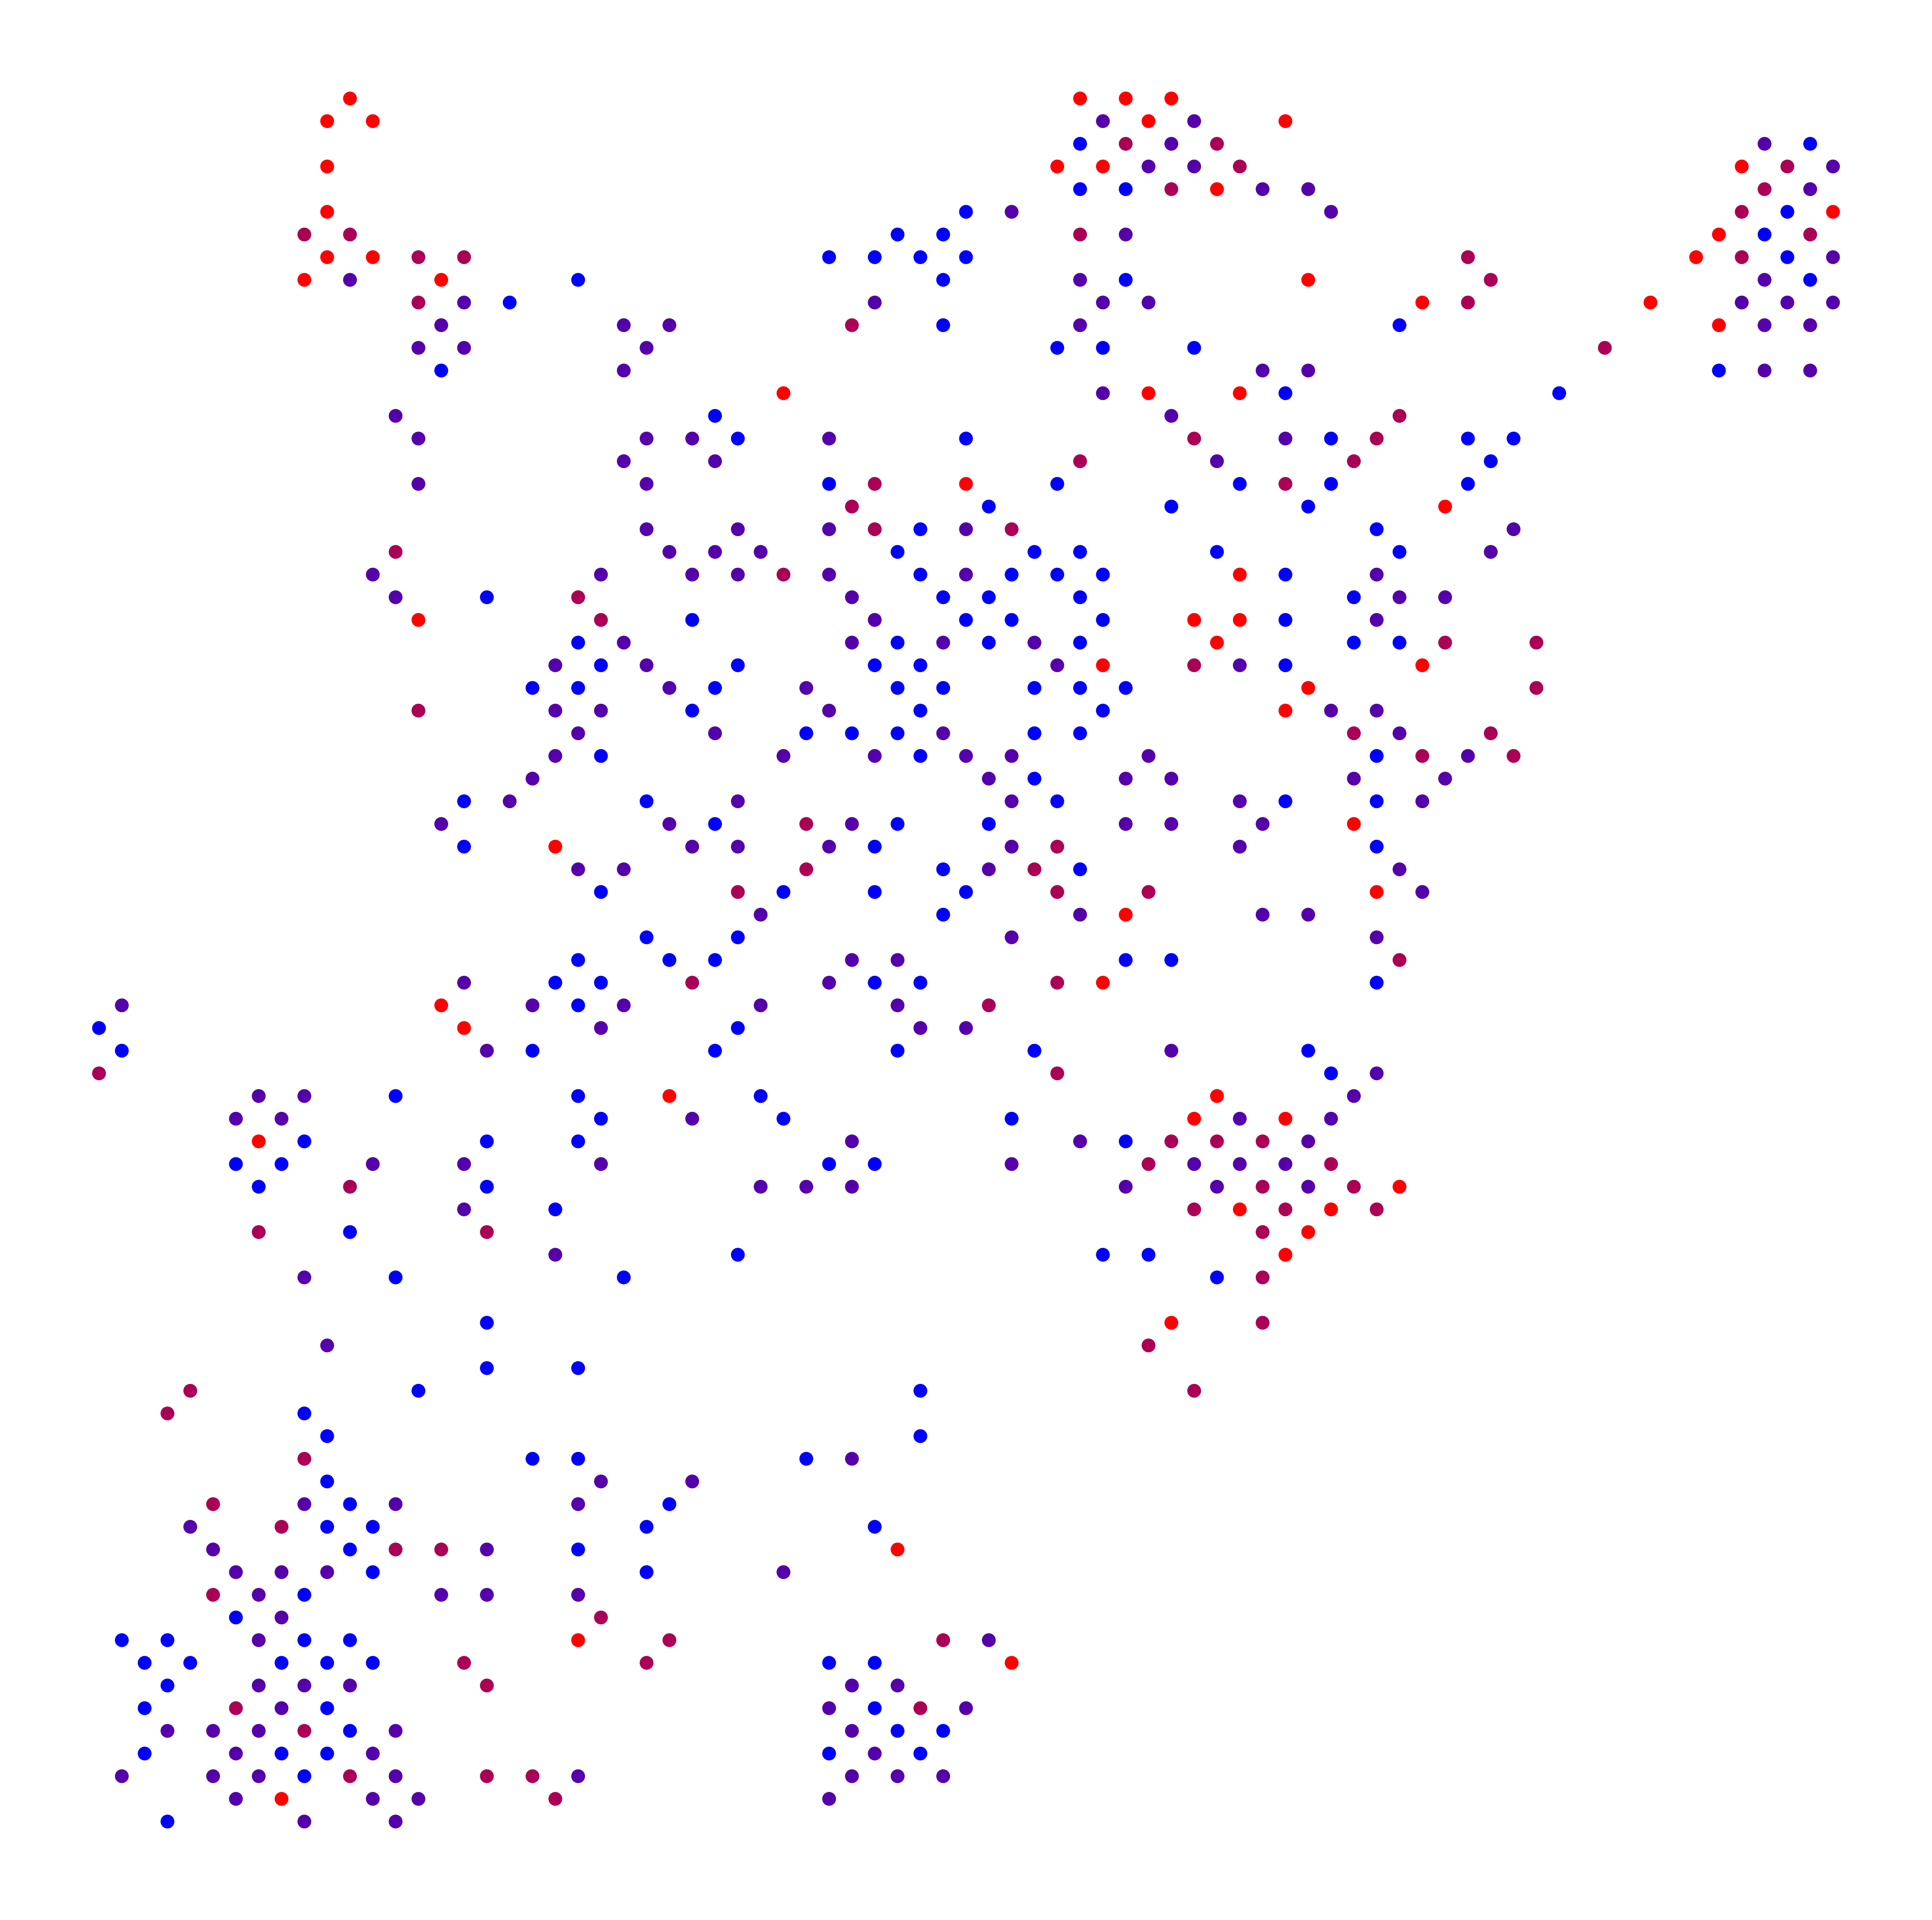

In [73]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


## Clustering

In [74]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=5,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=5, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,title,url,year,entities,temperature,color,x,y,cluster
509,Nobody knows how AI works,https://www.technologyreview.com/2024/03/05/10...,2024,"[Gemini, AI, Boaz Barak, Pornhub, Google DeepM...",2,#0000ff,380.519481,744.155844,-1
1935,Intelligent models for smarter decision-making,https://www.technologyreview.com/2021/02/18/10...,2021,"[Mustafa Suleyman, AI, withSiemens Digital Ind...",-1,#ff0000,702.597403,629.870130,n_7
1560,China wants to control how its famous livestre...,https://www.technologyreview.com/2022/07/04/10...,2022,"[Beijing, the University of Illinois, Universe...",0,#aa0055,474.025974,151.948052,-1


{'n_4', 'n_7', 'p_10', 'n_2', 'p_0', 'p_2', 'p_7', 'n_6', 'p_9', 'n_3', 'p_8', '-1', 'n_0', 'p_11', 'p_5', 'n_5', 'p_4', 'p_3', 'p_1', 'p_6', 'n_1'}


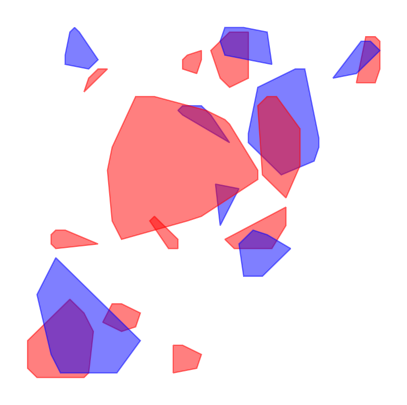

In [75]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [76]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,title,url,year,entities,temperature,color,x,y,cluster
1704,How AI could solve supply chain shortages and ...,https://www.technologyreview.com/2021/10/26/10...,2021,"[DHL, Amazon, Ford, Gemini, AI, University Col...",-1,#ff0000,255.844156,806.493506,n_0
